# Hidden Markov Models

Author: Mark Ho

This notebook implements a simple example of a hidden Markov model (HMM) and 
shows how different implementations have different runtime characteristics.

In [ ]:
from flippy import infer, condition, flip, draw_from
import pandas as pd
import seaborn as sns

### Rainy/Sunny HMM example (Russel & Norvig, 2010)

HMMs are defined by a transition model $P(x_{t + 1} \mid x_t)$ and a sensor model 
(aka observation model) $P(y_t \mid x_t)$, where $x_{t + 1}$ and $x_t$ are hidden states 
and $y_t$ is an observation at time $t$.

We can sample from an HMM by first sampling from an initial state distribution
and then sampling next states and observations for $T$ timesteps. 
This corresponds to the following joint distribution:
$$
P(x_{1:T}, y_{1:T}) = P(x_0)\prod_{t = 1}^T  P(y_t \mid x_t) P(x_{t + 1} \mid x_{t})
$$

In [31]:
def transition(state):
    if state == "rainy":
        next_state = "rainy" if flip(.7) else "sunny"
    else:
        next_state = "rainy" if flip(.3) else "sunny"
    return next_state

def sensor_model(state):
    if state == "rainy":
        return "umbrella" if flip(.9) else "no umbrella"
    else:
        return "umbrella" if flip(.2) else "no umbrella"


In [50]:
def generate_sequence(length):
    state_seq = ()
    obs_seq = ()
    state = draw_from(["rainy", "sunny"])
    for t in range(length):
        obs = sensor_model(state)
        obs_seq += (obs,)
        state_seq += (state,)
        state = transition(state)
    return state_seq, obs_seq

### Inferring latent states from observations (version 1)

HMMs can be used to perform *smoothing*, in which we observe a sequence of
observations $y_{1:T}$ and attempt to infer the hidden state at each time $t$, where $1 \leq t \leq T$.
That is, for each $t$, calculate:
$$
P(x_t \mid y_{1:T}) = \frac{\sum_{x_{1:t-1}, x_{t-1:T}}P(x_{1:T}, y_{1:T})}{\sum_{x_{1:T}}P(x_{1:T}, y_{1:T})}
$$

In FlipPy, the simplest way to implement this inference is to infer a posterior
over state sequences given observations and then compute marginals for each 
timestep like in the following cells. 

In [33]:
@infer
def state_seq_model(obs_seq):
    state = draw_from(["rainy", "sunny"])
    state_seq = ()
    for obs in obs_seq:
        # Save the state at time t
        state_seq += (state,)

        # Generate the observation 
        obs_ = sensor_model(state)

        # Condition on the observation
        condition(obs == obs_)

        # Transition to the next state
        state = transition(state)

    return state_seq


In [34]:
obs_seq = ("umbrella", "umbrella", "umbrella", "umbrella", "no umbrella")
state_seq_dist = state_seq_model(obs_seq)

(0.0, 1.0)

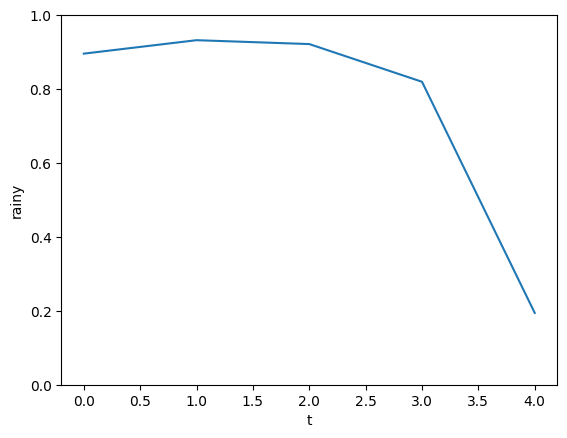

In [35]:
state_seq_marginals_df = []
for t in range(len(obs_seq)):
    marginal_dist = state_seq_dist.marginalize(lambda seq: seq[t])
    state_seq_marginals_df.append({'t': t, **dict(marginal_dist)})
ax = sns.lineplot(
    data=pd.DataFrame(state_seq_marginals_df),
    x='t', y='rainy'
)
ax.set_ylim(0, 1)

However, a problem with explicitly calculating a joint distribution over sequences and then
marginalizing is that the number of possible sequences increases combinatorially
with the length! Indeed, this way of doing things ultimately defeats the purpose
of HMMs, which is to perform efficient inference by taking advantage of the fact
that each state only depends on state at the previous timestep (the Markov property).
For instance, if you try to run `state_seq_model`
with a `obs_seq` repeated 3 times, it takes almost 30 seconds (at least on my computer).

In [36]:
# Running this cell will take about 30 seconds!
long_state_seq_dist = state_seq_model(obs_seq*3)

(0.0, 1.0)

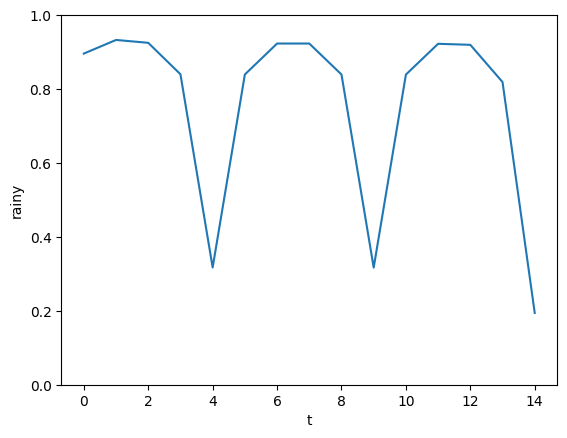

In [41]:
long_state_seq_marginals_df = []
for t in range(len(obs_seq)*3):
    marginal_dist = long_state_seq_dist.marginalize(lambda seq: seq[t])
    long_state_seq_marginals_df.append({'t': t, **dict(marginal_dist)})
ax = sns.lineplot(
    data=pd.DataFrame(long_state_seq_marginals_df),
    x='t', y='rainy'
)
ax.set_ylim(0, 1)

### Inferring latent states from observations (version 2)

How can we leverage the Markov property to do efficient smoothing?
Classic algorithms for HMMs, such as the [forward-backward algorithm](https://en.wikipedia.org/wiki/Forward%E2%80%93backward_algorithm),
take advantage of the Markov property and perform dynamic programming.
In FlipPy, we can mimic this approach by defining an inference
function that returns marginal posterior state for a time $t$, as in the following
cell. Then, we can calculate the marginals for each timestep by calling the model at different
times outside of inference. 

Note how this implementation runs **much** faster than the naive version above, which
calculates a joint distribution over possible state sequences.

In [44]:
@infer
def state_marginal_model(observations, t):
    assert t < len(observations)
    state = draw_from(["rainy", "sunny"])

    # We will return this at the end
    state_t = None 
    for t_, obs in list(enumerate(observations)):
        # Save the state at time t
        if t_ == t:
            state_t = state

        # generate observation
        obs_ = sensor_model(state)

        # Condition on the observation
        condition(obs == obs_)

        # Transition to the next state
        state = transition(state)

    return state_t

(0.0, 1.0)

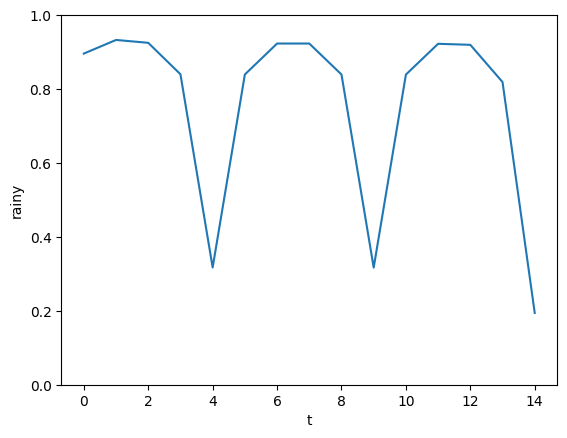

In [48]:
state_marginals_df = []
for t in range(len(obs_seq)*3):
    marginal_dist = state_marginal_model(obs_seq*3, t)
    state_marginals_df.append({'t': t, **dict(marginal_dist)})
ax = sns.lineplot(
    data=pd.DataFrame(state_marginals_df),
    x='t', y='rainy',
)
ax.set_ylim(0, 1)